<a href="https://colab.research.google.com/github/aikkel/MLEksammens/blob/main/crossValidatedYdft2TreeAndForestOnHueDroppingFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cell 0
!pip install ydf==0.4.0 -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 6.6 MB/s eta 0:00:00


In [ ]:
# cell 1
import ydf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# cell 2
path = 'https://raw.githubusercontent.com/aikkel/MLEksammens/main/color_namesV2.csv'
dataset = pd.read_csv(path)

# Drop RGB and Hex columns
dataset.drop(columns=["Red (8 bit)", "Green (8 bit)", "Blue (8 bit)", "Hex (24 bit)"], inplace=True)

# Assuming dataset contains Hue values in X
X = dataset[["Hue (degrees)"]]

# Define the number of clusters
k = 6  # Adjust as needed

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Get cluster centroids
centroids = kmeans.cluster_centers_

# Assign color labels based on proximity to centroids
def assign_color_label(hue):
    distances = np.abs(centroids - hue)
    closest_centroid_idx = np.argmin(distances)
    color_label = ["Red", "Orange", "Yellow", "Green", "Blue", "Purple"][closest_centroid_idx]
    return color_label

# Initialize color labels list
color_labels = [assign_color_label(hue) for hue in X["Hue (degrees)"]]

# Assign color labels to the dataset
dataset["ColorCategory"] = color_labels

# Print the unique color labels assigned to the dataset
print("Unique color labels assigned:", np.unique(color_labels))


Unique color labels assigned: ['Blue' 'Green' 'Orange' 'Purple' 'Red' 'Yellow']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


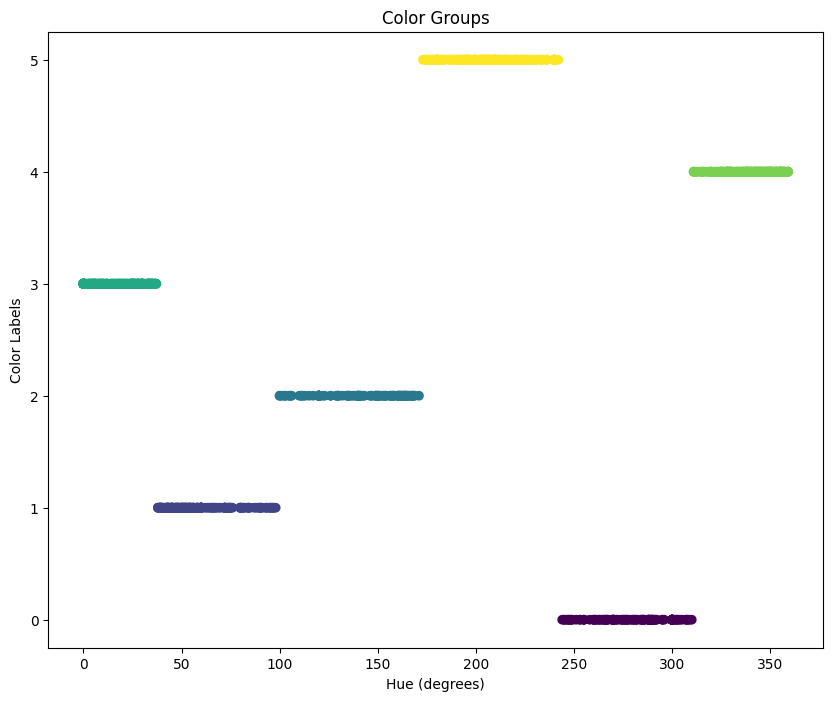

In [ ]:
# cell 3
# Create a mapping from color labels to numeric values for plotting
color_mapping = {label: idx for idx, label in enumerate(np.unique(color_labels))}
color_values = dataset["ColorCategory"].map(color_mapping)

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))

# Scatter plot of Hue values with assigned color labels
plt.scatter(X["Hue (degrees)"], color_values, c=color_values, cmap='viridis')

# Set labels and title
plt.xlabel('Hue (degrees)')
plt.ylabel('Color Labels')
plt.title('Color Groups')

# Show plot
plt.show()


In [ ]:
# cell 4
# Use color labels as target variable
y = color_labels

# Split the data into training and testing sets using train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

print("Training examples: ", len(train_dataset))
print("Testing examples: ", len(test_dataset))

Training examples:  1038
Testing examples:  260


In [ ]:
# cell 5
# Train the decision tree model with regularization
tree_model = ydf.CartLearner(label="ColorCategory", min_examples=5).train(train_dataset)
tree_model.plot_tree()

# Evaluate the decision tree model
print("Decision Tree Test Accuracy:", tree_model.evaluate(test_dataset).accuracy)

Train model on 1038 examples
Model trained in 0:00:00.004696
Decision Tree Test Accuracy: 0.9961538461538462


In [ ]:
# Cell 6 - Cross-validation for Decision Tree using YDF
tree_learner = ydf.CartLearner(label="ColorCategory", min_examples=1)

# Perform cross-validation with 5 folds
tree_cv_evaluation = tree_learner.cross_validation(dataset, folds=5)

# Print the evaluation object to understand its structure
print(tree_cv_evaluation)

tree_model.plot_tree()

accuracy: 0.997689
confusion matrix:
    label (row) \ prediction (col)
    +--------+--------+--------+--------+--------+--------+--------+
    |        | Purple |    Red | Yellow |  Green | Orange |   Blue |
    +--------+--------+--------+--------+--------+--------+--------+
    | Purple |    314 |      0 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |    Red |      0 |    269 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    | Yellow |      0 |      0 |    244 |      0 |      0 |      1 |
    +--------+--------+--------+--------+--------+--------+--------+
    |  Green |      0 |      0 |      0 |    206 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    | Orange |      0 |      0 |      1 |      0 |    132 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |   Blue |      0 |      1 

In [ ]:
# cell 7
# Train the random forest model with hyperparameters to prevent overfitting
forest_model = ydf.RandomForestLearner(
    label="ColorCategory",
    num_trees=100,               # Increase the number of trees
    max_depth=10,                # Limit the maximum depth of the trees
    min_examples=10,             # Minimum number of examples per node
    bootstrap_training_dataset=True, # Use bootstrap sampling for training each tree
    honest=True,                 # Use honest trees
    random_seed=42               # Set a random seed for reproducibility
).train(train_dataset)

# Optionally, plot a tree if you want to visualize it
# Note: Plotting might not be directly supported for a forest, usually done for single trees.
# forest_model.plot_tree()


Train model on 1038 examples
Model trained in 0:00:00.082985


In [ ]:
# Cell 8 - Cross-validation for Random Forest using YDF
forest_learner = ydf.RandomForestLearner(label="ColorCategory")

# Perform cross-validation with 5 folds
forest_cv_evaluation = forest_learner.cross_validation(dataset, folds=5)
# try on te test set

# Print the evaluation object to understand its structure
print(forest_cv_evaluation)
forest_model.plot_tree()


accuracy: 0.998459
confusion matrix:
    label (row) \ prediction (col)
    +--------+--------+--------+--------+--------+--------+--------+
    |        | Purple |    Red | Yellow |  Green | Orange |   Blue |
    +--------+--------+--------+--------+--------+--------+--------+
    | Purple |    314 |      0 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |    Red |      0 |    269 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    | Yellow |      0 |      0 |    245 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |  Green |      0 |      0 |      0 |    206 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    | Orange |      0 |      0 |      1 |      0 |    132 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |   Blue |      0 |      1 

In [ ]:
# cell 9
# Evaluate the random forest model
evaluation_results = forest_model.evaluate(test_dataset)
print("Random Forest Evaluation Results: ", evaluation_results)

Random Forest Evaluation Results:  accuracy: 0.996154
confusion matrix:
    label (row) \ prediction (col)
    +--------+--------+--------+--------+--------+--------+--------+
    |        | Purple |    Red | Yellow |  Green |   Blue | Orange |
    +--------+--------+--------+--------+--------+--------+--------+
    | Purple |     55 |      0 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |    Red |      0 |     50 |      0 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    | Yellow |      0 |      0 |     46 |      0 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |  Green |      0 |      0 |      0 |     44 |      0 |      0 |
    +--------+--------+--------+--------+--------+--------+--------+
    |   Blue |      0 |      1 |      0 |      0 |     30 |      0 |
    +--------+--------+--------+--------+--------+--------+------

In [ ]:
# # cell 10
# # Save the decision tree model to Google Drive
# tree_model.save("/content/drive/MyDrive/Colab Notebooks/decision_tree_model")

# # Save the random forest model to Google Drive
# forest_model.save("/content/drive/MyDrive/Colab Notebooks/random_forest_model")
